# Simple Example Showing UQ With PCE

This example shows some basic functionality of UncertainSCI using the polynomial Chaos emulators (PCE) to quantify uncertainty in a 1D function.  It is essentially identical to `demos/build_pce.py` and uses a [1D Laplacian ODE](../models.html) as a model with three parameters

In [1]:
import numpy as np
from matplotlib import pyplot as plt

from UncertainSCI.distributions import BetaDistribution
from UncertainSCI.model_examples import laplace_ode_1d
from UncertainSCI.pce import PolynomialChaosExpansion

from UncertainSCI.vis import piechart_sensitivity, quantile_plot, mean_stdev_plot


## Model Parameter setup

The first step in running UncertainSCI is to specify the parameter distributions and the capacity of the PCE model (polynomial order).

### Distributions

In [2]:
# Number of parameters
Nparams = 3

# Three independent parameters with different Beta distributions
p1 = BetaDistribution(alpha=0.5, beta=1.)
p2 = BetaDistribution(alpha=1., beta=0.5)
p3 = BetaDistribution(alpha=1., beta=1.)

plabels = ['a', 'b', 'z']

### Polynomial Order

How complicated the model is

In [3]:
# # Polynomial order
order = 5

## Forward Model

$$
-\frac{d}{dx} a(x,p) \cdot \frac{d}{dx} u(x,p) = f(x)
$$

with $x$ in $[-1,1]$ discretized with $N$ points, where $a(x,p)$ is a Fourier-Series-parameterized diffusion model with the variables $p_j=[a, b, z]$.  See the `laplace_ode_1d` [method](../models.html) or `UncertainSCI/model_examples.py` for details.

In [4]:
N = 100
x, model = laplace_ode_1d(Nparams, N=N)

## Running PCE in UncertainSCI

The steps to running PCE in UncertainSCI are
- create PCE object
- generate parameter samples
- run parameter sets in the forward model
- give model output to PCE
- compute output statistics

### Create PCE object and Build Sample Set

With the parameter distribution created and polynomial order set, we can create the PCE object and generate a parameter set that will efficiently and accurately estimate the output distribution of the model.  UncertainSCI adds an extra 10 parameter sets as a precaution.  

In [5]:

pce = PolynomialChaosExpansion(distribution=[p1, p2, p3], order=order, plabels=plabels)
pce.generate_samples()

print('This queries the model {0:d} times'.format(pce.samples.shape[0]))

Precomputing data for Jacobi parameters (alpha,beta) = (-0.500000, 0.000000)...Done
This queries the model 66 times


### Run Parameter Sets in the Forward Model

We query each parameter set in sequence to run in our Laplacian ODE model and collect the results

In [6]:
model_output = np.zeros([pce.samples.shape[0], N])
for ind in range(pce.samples.shape[0]):
    model_output[ind, :] = model(pce.samples[ind, :])


### Build PCE from Model Outputs

With the collated model solutions, the output distributions can be estimated using PCE

In [7]:
pce.build(model_output=model_output)

array([1.75571628e-37, 5.64860235e-17, 2.10743598e-16, 4.30180091e-16,
       6.73615485e-16, 8.98426649e-16, 1.06808811e-15, 1.15833221e-15,
       1.16057868e-15, 1.08209494e-15, 9.43231789e-16, 7.72726181e-16,
       6.02299430e-16, 4.61625174e-16, 3.74362183e-16, 3.55551159e-16,
       4.10403164e-16, 5.34387196e-16, 7.14489737e-16, 9.31478341e-16,
       1.16290358e-15, 1.38643597e-15, 1.58302359e-15, 1.73934375e-15,
       1.84914225e-15, 1.91328322e-15, 1.93860602e-15, 1.93592175e-15,
       1.91761943e-15, 1.89536658e-15, 1.87829599e-15, 1.87191182e-15,
       1.87777401e-15, 1.89387162e-15, 1.91549769e-15, 1.93639635e-15,
       1.94995954e-15, 1.95029022e-15, 1.93300605e-15, 1.89571844e-15,
       1.83817752e-15, 1.76211869e-15, 1.67087823e-15, 1.56886365e-15,
       1.46096875e-15, 1.35201633e-15, 1.24629417e-15, 1.14722754e-15,
       1.05720583e-15, 9.77557484e-16, 9.08648189e-16, 8.50065649e-16,
       8.00849025e-16, 7.59724059e-16, 7.25312441e-16, 6.96294722e-16,
      

### Compute Output Statistics

With the PCE built, statistics can be calculated for each point in the solution space (x).

In [8]:
## Postprocess PCE: statistics are computable:
mean = pce.mean()
stdev = pce.stdev()
global_sensitivity, variable_interactions = pce.global_sensitivity()
quantiles = pce.quantile([0.25, 0.5, 0.75]) #  0.25, median, 0.75 quantile

## Output Visualizations

To help understand and interpret UQ statistics, we've included some plotting tools for 1D data.

<AxesSubplot:title={'center':'Mean $\\pm$ standard deviation'}, xlabel='$x$'>

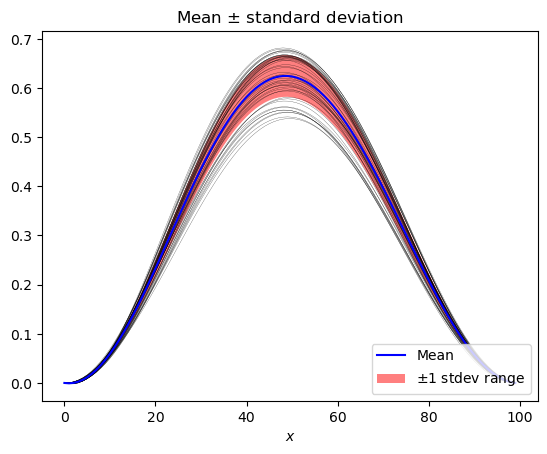

In [9]:
mean_stdev_plot(pce, ensemble=50)

<AxesSubplot:title={'center':'Median + quantile bands'}, xlabel='$x$'>

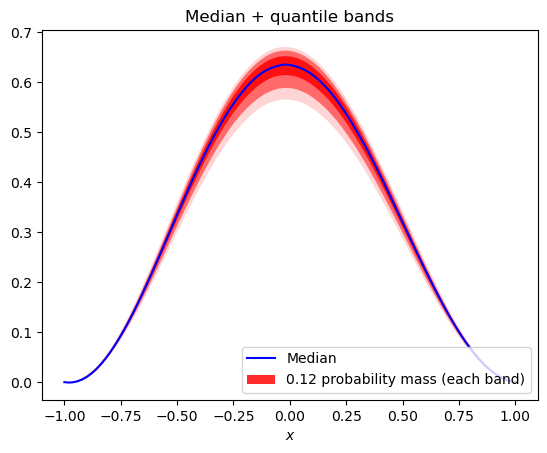

In [10]:
quantile_plot(pce, bands=3, xvals=x, xlabel='$x$')

<AxesSubplot:title={'center':'Sensitivity due to variable interactions'}>

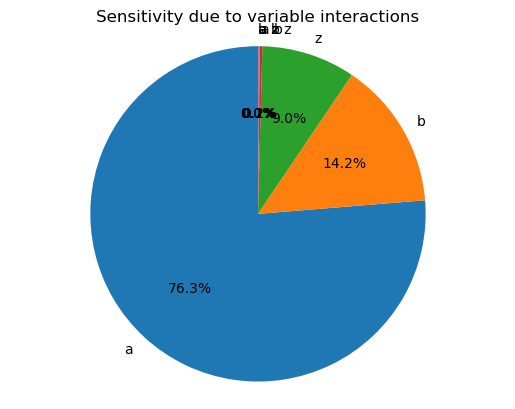

In [11]:
piechart_sensitivity(pce)